# Цель лабораторной работы
Изучить сложные способы подготовки выборки и подбора гиперпараметров на примере метода ближайших соседей<cite data-cite="ue:lab4"></cite>.

# Задание
Требуется выполнить следующие действия<cite data-cite="ue:lab4"></cite>:

1. Выбрать набор данных (датасет) для&nbsp;решения задачи классификации или регресии.
2. В&nbsp;случае необходимости проведите удаление или заполнение пропусков и кодирование категориальных признаков.
3. С&nbsp;использованием метода `train_test_split` разделите выборку на&nbsp;обучающую и тестовую.
4. Обучите модель ближайших соседей для&nbsp;произвольно заданного гиперпараметра $K$. Оцените качество модели с&nbsp;помощью трех подходящих для&nbsp;задачи метрик.
5. Постройте модель и оцените качество модели с&nbsp;использованием кросс-валидации. Проведите эксперименты с&nbsp;тремя различными стратегиями кросс-валидации.
6. Произведите подбор гиперпараметра $K$ с&nbsp;использованием `GridSearchCV` и кросс-валидации.
7. Повторите пункт&nbsp;4 для&nbsp;найденного оптимального значения гиперпараметра $K$. Сравните качество полученной модели с&nbsp;качеством модели, полученной в&nbsp;пункте&nbsp;4.
8. Постройте кривые обучения и валидации.

# Ход выполнения работы

Подключим все необходимые библиотеки и настроим отображение графиков<cite data-cite="doc:ipython,doc:seaborn"></cite>:

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.impute import MissingIndicator
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import median_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold, RepeatedKFold, ShuffleSplit
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.model_selection import learning_curve, validation_curve
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler

# Enable inline plots
%matplotlib inline

# Set plots formats to save high resolution PNG
from IPython.display import set_matplotlib_formats
set_matplotlib_formats("retina")

Зададим ширину текстового представления данных, чтобы в&nbsp;дальнейшем текст в&nbsp;отчёте влезал на&nbsp;А4<cite data-cite="doc:pandas"></cite>:

In [2]:
pd.set_option("display.width", 70)

## Предварительная подготовка данных

В&nbsp;качестве набора данных используются датасет покзаателей недоедания по странам мира- https://www.kaggle.com/ruchi798/malnutrition-across-the-globe

In [3]:
data = pd.read_csv("./data/country-wise-average.csv")

Проверим полученные типы:

In [4]:
data.dtypes

Country                   object
Income Classification    float64
Severe Wasting           float64
Wasting                  float64
Overweight               float64
Stunting                 float64
Underweight              float64
U5 Population ('000s)    float64
dtype: object

Посмотрим на данные в&nbsp;данном наборе данных:

In [5]:
data.head()

,Country,Income Classification,Severe Wasting,Wasting,Overweight,Stunting,Underweight,U5 Population ('000s)
0,AFGHANISTAN,0.0,3.033333,10.350000,5.125000,47.775000,30.375000,4918.561500
1,ALBANIA,2.0,4.075000,7.760000,20.800000,24.160000,7.700000,232.859800
2,ALGERIA,2.0,2.733333,5.942857,12.833333,19.571429,7.342857,3565.213143
3,ANGOLA,1.0,2.400000,6.933333,2.550000,42.633333,23.600000,3980.054000
4,ARGENTINA,2.0,0.200000,2.150000,11.125000,10.025000,2.600000,3613.651750


&nbsp;Проверим размер набора данных:

In [6]:
data.shape

(152, 8)

Проверим основные статистические характеристики набора данных:

In [7]:
data.describe()

,Income Classification,Severe Wasting,Wasting,Overweight,Stunting,Underweight,U5 Population ('000s)
count,152.000000,140.000000,150.000000,149.000000,151.000000,150.000000,152.000000
mean,1.427632,2.168650,6.599257,7.201638,25.814728,13.503047,4042.927052
std,0.967019,1.708939,4.481723,4.649144,14.686807,10.895839,13164.191927
min,0.000000,0.000000,0.000000,0.962500,1.000000,0.100000,1.000000
25%,1.000000,0.900000,3.262500,3.850000,13.485000,4.305000,241.765813
50%,1.000000,1.872500,5.710714,6.300000,24.160000,10.380000,981.233486
75%,2.000000,2.822727,8.740476,9.080000,36.564935,19.496875,3002.433080
max,3.000000,11.400000,23.650000,26.500000,57.600000,46.266667,123014.491000


Проверим наличие пропусков в&nbsp;данных:

In [8]:
data.isnull().sum()

Country                   0
Income Classification     0
Severe Wasting           12
Wasting                   2
Overweight                3
Stunting                  1
Underweight               2
U5 Population ('000s)     0
dtype: int64

Уберем пропуски используя функции из прошлых лабораторных.

In [9]:
from sklearn.impute import SimpleImputer


def impute_num_col(dataset, column, strategy_param):
    temp_data = dataset[[column]]
    imp_num = SimpleImputer(strategy=strategy_param)
    data_num_imp = imp_num.fit_transform(temp_data)
    return data_num_imp


def get_empty_num_columns(data):
    num_cols = []
    for col in data.columns:
        # Количество пустых значений
        temp_null_count = data[data[col].isnull()].shape[0]
        dt = str(data[col].dtype)
        if temp_null_count>0 and (dt=='float64' or dt=='int64'):
            num_cols.append(col)
    return num_cols


def impute_num_cols(data):
    num_cols = get_empty_num_columns(data)
    for col in num_cols:
        cols_data_imp = impute_num_col(dataset=data, column=col, strategy_param='median')
        data[col] = cols_data_imp
    return data

data = impute_num_cols(data)
data.isnull().sum()

Country                  0
Income Classification    0
Severe Wasting           0
Wasting                  0
Overweight               0
Stunting                 0
Underweight              0
U5 Population ('000s)    0
dtype: int64

## Разделение данных
Разделим данные на&nbsp;целевой столбец и признаки:

In [10]:
#убираем категориальный признак
X = data.drop("Country", axis=1)
# целевой столбец - Stunting
X = X.drop("Stunting", axis = 1)
y = data["Stunting"]

In [11]:
print(X.head(), "\n")
print(y.head())

   Income Classification  Severe Wasting    Wasting  Overweight  \
0                    0.0        3.033333  10.350000    5.125000   
1                    2.0        4.075000   7.760000   20.800000   
2                    2.0        2.733333   5.942857   12.833333   
3                    1.0        2.400000   6.933333    2.550000   
4                    2.0        0.200000   2.150000   11.125000   

   Underweight  U5 Population ('000s)  
0    30.375000            4918.561500  
1     7.700000             232.859800  
2     7.342857            3565.213143  
3    23.600000            3980.054000  
4     2.600000            3613.651750   

0    47.775000
1    24.160000
2    19.571429
3    42.633333
4    10.025000
Name: Stunting, dtype: float64


In [12]:
print(X.shape)
print(y.shape)

(152, 6)
(152,)


Предобработаем данные, чтобы методы работали лучше:

In [13]:
columns = X.columns
scaler = StandardScaler()
X = scaler.fit_transform(X)
pd.DataFrame(X, columns=columns).describe()

,Income Classification,Severe Wasting,Wasting,Overweight,Underweight,U5 Population ('000s)
count,1.520000e+02,1.520000e+02,1.520000e+02,1.520000e+02,1.520000e+02,1.520000e+02
mean,5.331992e-17,-1.431603e-16,-5.697197e-17,9.933574e-17,-7.304099e-18,2.191230e-18
std,1.003306e+00,1.003306e+00,1.003306e+00,1.003306e+00,1.003306e+00,1.003306e+00
min,-1.481203e+00,-1.311149e+00,-1.484211e+00,-1.355626e+00,-1.237946e+00,-3.080545e-01
25%,-4.436783e-01,-7.292195e-01,-7.435210e-01,-7.182705e-01,-8.474387e-01,-2.897046e-01
50%,-4.436783e-01,-1.667116e-01,-1.975589e-01,-1.925886e-01,-2.855341e-01,-2.333463e-01
75%,5.938463e-01,3.619602e-01,4.732596e-01,4.109923e-01,5.446418e-01,-7.930100e-02
max,1.631371e+00,5.656318e+00,3.844250e+00,4.208976e+00,3.039261e+00,9.067390e+00


Разделим выборку на&nbsp;тренировочную и тестовую:

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                            test_size=0.25, random_state=346705925)

In [15]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(114, 6)
(38, 6)
(114,)
(38,)


## Модель ближайших соседей для произвольно заданного гиперпараметра $K$

Напишем функцию, которая считает метрики построенной модели:

In [16]:
def test_model(model):
    print("mean_absolute_error:",
          mean_absolute_error(y_test, model.predict(X_test)))
    print("median_absolute_error:",
          median_absolute_error(y_test, model.predict(X_test)))
    print("r2_score:",
          r2_score(y_test, model.predict(X_test)))

Попробуем метод ближайших соседей с&nbsp;гиперпараметром $K=5$:

In [17]:
reg_5 = KNeighborsRegressor(n_neighbors=5)
reg_5.fit(X_train, y_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                    weights='uniform')

Проверим метрики построенной модели:

In [18]:
test_model(reg_5)

mean_absolute_error: 5.679961074013704
median_absolute_error: 5.154880952380953
r2_score: 0.7767479593612954


Видно, что средние ошибки не&nbsp;очень показательны для&nbsp;одной модели, они больше подходят для&nbsp;сравнения разных моделей. В&nbsp;тоже время коэффициент детерминации неплох сам по&nbsp;себе, в&nbsp;данном случае модель более-менее состоятельна.

## Использование кросс-валидации

Проверим различные стратегии кросс-валидации. Для&nbsp;начала посмотрим классический K-fold:

In [19]:
scores = cross_val_score(KNeighborsRegressor(n_neighbors=5), X, y,
                         cv=KFold(n_splits=10), scoring="r2")
print(scores)
print(scores.mean(), "±", scores.std())

[0.79968097 0.70108768 0.69704128 0.54083519 0.8857852  0.71481073
 0.83108757 0.81747664 0.74525158 0.86043739]
0.7593494245375407 ± 0.09672859064176105


In [20]:
scores = cross_val_score(KNeighborsRegressor(n_neighbors=5), X, y,
                         cv=RepeatedKFold(n_splits=5, n_repeats=2),
                         scoring="r2")
print(scores)
print(scores.mean(), "±", scores.std())

[0.71273545 0.81427494 0.81875679 0.69587569 0.78358485 0.72078542
 0.7600029  0.78085276 0.78310934 0.80034909]
0.7670327230765582 ± 0.04115866885841858


In [21]:
scores = cross_val_score(KNeighborsRegressor(n_neighbors=5), X, y,
                         cv=ShuffleSplit(n_splits=10), scoring="r2")
print(scores)
print(scores.mean(), "±", scores.std())

[0.7304666  0.80040793 0.78740169 0.55269476 0.60412958 0.76264391
 0.53697328 0.74959248 0.81696743 0.58958041]
0.6930858071881192 ± 0.10387308656552037


# Подбор гиперпараметра $K$

Введем список настраиваемых параметров:

In [22]:
n_range = np.array(range(1, 50, 2))
tuned_parameters = [{'n_neighbors': n_range}]
n_range

array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33,
       35, 37, 39, 41, 43, 45, 47, 49])

Запустим подбор параметра:

In [23]:
gs = GridSearchCV(KNeighborsRegressor(), tuned_parameters,
                  cv=ShuffleSplit(n_splits=10), scoring="r2",
                  return_train_score=True, n_jobs=-1)
gs.fit(X, y)
gs.best_params_

{'n_neighbors': 3}

Проверим результаты при&nbsp;разных значения гиперпараметра на&nbsp;тренировочном наборе данных:

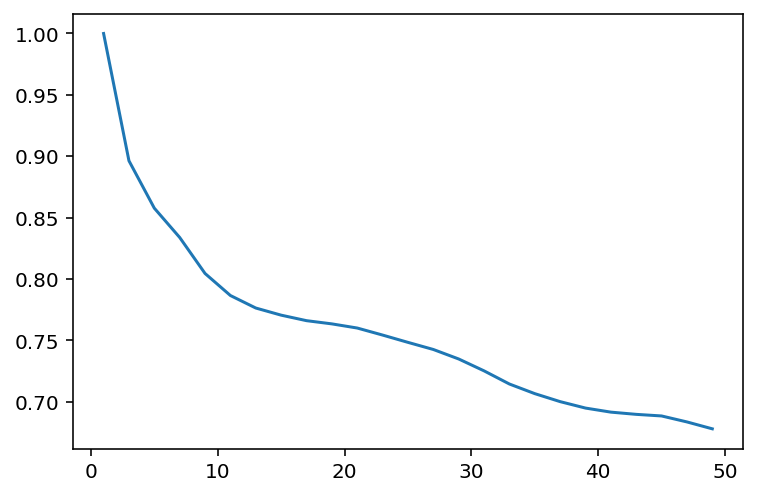

In [24]:
plt.plot(n_range, gs.cv_results_["mean_train_score"]);

Очевидно, что для&nbsp;$K=1$ на&nbsp;тренировочном наборе данных мы находим ровно ту же точку, что и нужно предсказать, и чем больше её соседей мы берём — тем меньше точность.

На&nbsp;тестовом наборе данных картина сильно интереснее:

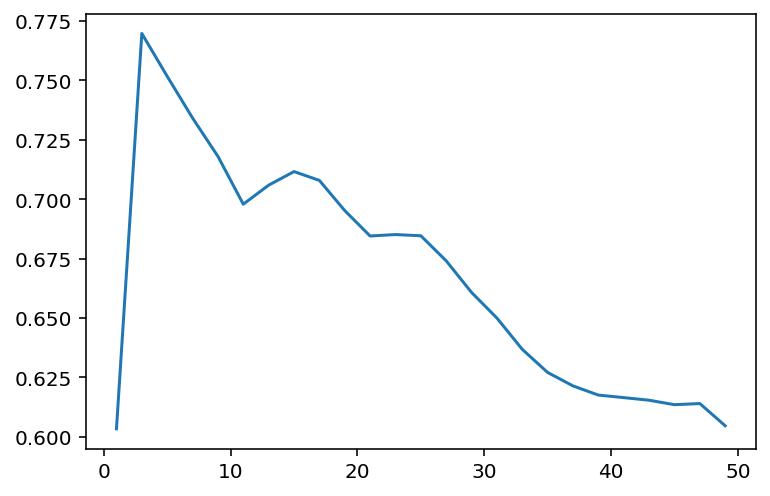

In [25]:
plt.plot(n_range, gs.cv_results_["mean_test_score"]);

Выходит, что сначала соседей слишком мало (высоко влияние выбросов), а затем количество соседей постепенно становится слишком велико, и среднее значение по&nbsp;этим соседям всё больше и больше оттягивает значение от&nbsp;истинного.

Проверим получившуюся модель:

In [26]:
reg = KNeighborsRegressor(**gs.best_params_)
reg.fit(X_train, y_train)
test_model(reg)

mean_absolute_error: 5.1802052796131735
median_absolute_error: 4.60282356532357
r2_score: 0.8016490414533068


В&nbsp;целом получили примерно тот же результат. Очевидно, что проблема в&nbsp;том, что данный метод и так показал достаточно плохой результат для&nbsp;данной выборки.

Построим кривую обучения<cite data-cite="doc:sklearn"></cite>:

In [27]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None):
    train_sizes=np.linspace(.1, 1.0, 5)

    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=-1, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1,
                     color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

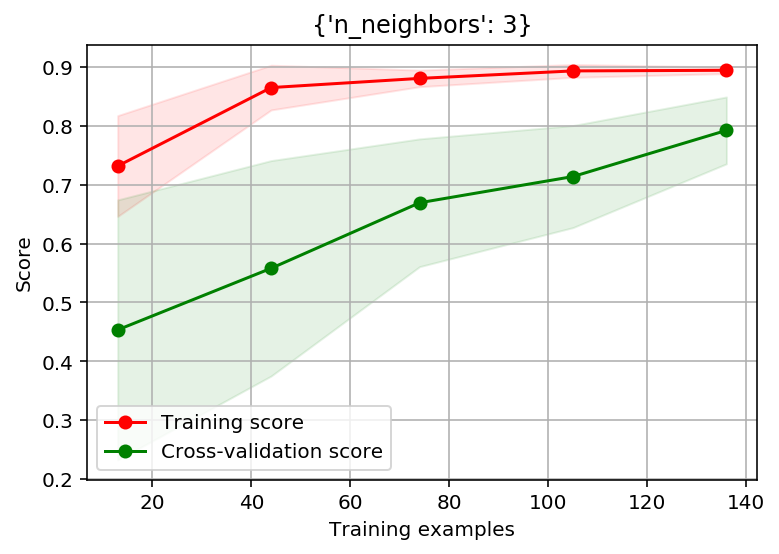

In [28]:
plot_learning_curve(reg, str(gs.best_params_), X, y,
                    cv=ShuffleSplit(n_splits=10));

Построим кривую валидации:

In [29]:
def plot_validation_curve(estimator, title, X, y, 
                          param_name, param_range, cv, 
                          scoring="accuracy"):
                                                   
    train_scores, test_scores = validation_curve(
        estimator, X, y, param_name=param_name,
        param_range=param_range,
        cv=cv, scoring=scoring, n_jobs=-1)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.title(title)
    plt.xlabel(param_name)
    plt.ylabel("Score")
    plt.ylim(0.0, 1.1)
    lw = 2
    plt.plot(param_range, train_scores_mean, label="Training score",
                 color="darkorange", lw=lw)
    plt.fill_between(param_range, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.2,
                     color="darkorange", lw=lw)
    plt.plot(param_range, test_scores_mean,
                 label="Cross-validation score",
                 color="navy", lw=lw)
    plt.fill_between(param_range, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.2,
                     color="navy", lw=lw)
    plt.legend(loc="best")
    return plt

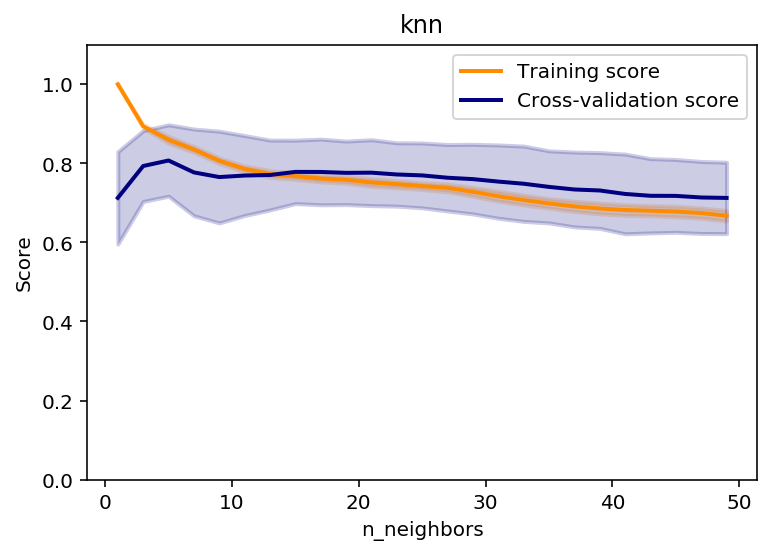

In [30]:
plot_validation_curve(KNeighborsRegressor(), "knn", X, y, 
                      param_name="n_neighbors", param_range=n_range, 
                      cv=ShuffleSplit(n_splits=10), scoring="r2");